In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from lib.lib import Import_data

path = Import_data()
# get all files in the directory
files = os.listdir(path)
print(files)

Path to dataset files: C:\Users\kskdu\.cache\kagglehub\datasets\arashnic\earthquake-magnitude-damage-and-impact\versions\6
['csv_building_damage_assessment.csv', 'csv_building_ownership_and_use.csv', 'csv_building_structure.csv', 'csv_household_demographics.csv', 'csv_household_earthquake_impact.csv', 'csv_household_resources.csv', 'csv_individual_demographics.csv', 'mapping.csv', 'ward_vdcmun_district_name_mapping.csv']


In [245]:
building_structure = pd.read_csv(path + "/csv_building_structure.csv")
dmg_assesment = pd.read_csv(path + "/csv_building_damage_assessment.csv")

building_structure.keys()

C:\Users\kskdu\AppData\Local\Temp\ipykernel_12172\4115963309.py:2: DtypeWarning: Columns (5,17,29,34,35,36,37,38,39,40,41,42,43,47,50) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [246]:
# Filter out uneeded rows
dmg_assesment = dmg_assesment.drop(columns=[col for col in dmg_assesment.columns if 'has_geotechnical_risk_' not in col and col != 'building_id'])

In [247]:
dmg_assesment.keys()

Index(['building_id', 'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_landslide',
       'has_geotechnical_risk_rock_fall', 'has_geotechnical_risk_flood',
       'has_geotechnical_risk_other'],
      dtype='object')

In [248]:
building_structure.keys()

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [249]:
# Merge dmg assesment into building structure on building id column
building_structure = building_structure.merge(dmg_assesment, on='building_id')
building_structure.keys()

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed',
       'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'ha

In [250]:
len(building_structure)

762106

In [251]:
# Remove id columns, columns containing post_eq and technical_solution_proposed and position
building_structure = building_structure.drop(columns=[col for col in building_structure.columns if 'id' in col or 'post_eq' in col or 'technical_solution_proposed' in col or 'position' in col])

In [252]:
len(building_structure)

762106

In [253]:
# Dropping floors above 6
building_structure = building_structure[building_structure["count_floors_pre_eq"] < 6]

In [254]:
len(building_structure)

761661

In [255]:
# Dropping rows with plinith area above 1500
building_structure = building_structure[building_structure["plinth_area_sq_ft"] <= 1500]

In [256]:
# One hot encode the relevant columns
building_structure_onehot = pd.get_dummies(building_structure, columns=["foundation_type", "plan_configuration", 'land_surface_condition', 'roof_type', 'ground_floor_type', 'other_floor_type'] )

In [257]:
# Changing damage categories into numerical values
building_structure["damage_grade"] = building_structure["damage_grade"].replace({"Grade 1": 0, "Grade 2": 1, "Grade 3": 2, "Grade 4": 3, "Grade 5": 4})

C:\Users\kskdu\AppData\Local\Temp\ipykernel_12172\555852273.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [258]:
building_structure.keys()

Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_rock_fall',
       'has_geotechnical_risk_flood', 'has_geotechnical_risk_other'],
      dtype='object')

In [259]:
# Translating category columns to category type for native category support
categorical_columns = [
    "land_surface_condition", 
    "foundation_type", 
    "roof_type", 
    "ground_floor_type",
    "other_floor_type",
    "plan_configuration",
]

for col in categorical_columns:
    building_structure[col] = building_structure[col].astype('category')

In [260]:
print(building_structure.isna().sum())
building_structure = building_structure.dropna()

count_floors_pre_eq                        0
age_building                               0
plinth_area_sq_ft                          0
height_ft_pre_eq                           0
land_surface_condition                     0
foundation_type                            0
roof_type                                  0
ground_floor_type                          0
other_floor_type                           0
plan_configuration                         1
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_superstructure_cement_mortar_stone     0
has_superstructure_mud_mortar_brick        0
has_superstructure_cement_mortar_brick     0
has_superstructure_timber                  0
has_superstructure_bamboo                  0
has_superstructure_rc_non_engineered       0
has_superstructure_rc_engineered           0
has_superstructure_other                   0
damage_grade                              12
has_geotec

In [271]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def train(X_train, y_train, X_val, y_val,params, rounds):
    # Create the LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=rounds,
        valid_sets=[train_data, val_data],
    )

    return model

In [270]:
def test_classification(model, X_test, y_test, keys):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Feature importance
    importance = model.feature_importance(importance_type='split')
    feature_names = keys
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print("Feature Importance (top 10):")
    for feature, importance in feature_importance[:10]:
        print(f"{feature}: {importance}")

    return accuracy

In [263]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_regression(model, X, y_true):
    y_pred = model.predict(X)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

In [267]:
categorical_columns = [
    'land_surface_condition', 
    'foundation_type', 
    'roof_type', 
    'ground_floor_type', 
    'other_floor_type', 
    'plan_configuration'
]

# Use pandas get_dummies function to one-hot encode
X = pd.get_dummies(
    building_structure.drop(columns=["damage_grade"]), 
    columns=categorical_columns,
    drop_first=False,  # Set to True if you want to avoid multicollinearity
    prefix=categorical_columns,
    prefix_sep='_'
)

keys = X.keys()
X = X.to_numpy()

In [ ]:
y = building_structure["damage_grade"].astype("Int64").to_numpy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Original training distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Sampled training distribution:", Counter(y_train))

In [ ]:
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # Number of damage grade classes
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': -1,        # -1 means no limit
    'num_leaves': 31,       # Maximum tree leaves for base learners
    'feature_fraction': 0.8, # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8, # Randomly select a subset of data without resampling
    'bagging_freq': 5,       # Perform bagging every 5 iterations
    'verbose': -1,          # Suppress printing messages
    'boosting_type': 'gbdt'  # Traditional Gradient Boosting Decision Tree
}

rounds=100

model = train(X_train, y_train, X_val, y_val, params, rounds)
print(test_classification(model, X_val, y_val, keys=keys),
test_classification(model, X_test, y_test))

Original training distribution: Counter({np.int64(4): 192748, np.int64(3): 128416, np.int64(2): 94980, np.int64(1): 60485, np.int64(0): 54141})
Sampled training distribution: Counter({np.int64(2): 192748, np.int64(3): 192748, np.int64(4): 192748, np.int64(1): 192748, np.int64(0): 192748})


TypeError: test_classification() got an unexpected keyword argument 'keys'

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

regression_params = {
    'objective': 'regression',        # Changed to regression
    'metric': 'MAE',                 # Changed to RMSE (root mean squared error)
    'learning_rate': 0.01,
    'max_depth': -1,                  # -1 means no limit
    'num_leaves': 31,                 # Maximum tree leaves for base learners
    'feature_fraction': 0.8,          # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8,          # Randomly select a subset of data without resampling
    'bagging_freq': 5,                # Perform bagging every 5 iterations
    'verbose': -1,                    # Suppress printing messages
    'n_estimators': 1000,             # Number of boosting iterations
    'boosting_type': 'gbdt'           # Traditional Gradient Boosting Decision Tree
}

rounds = 1000
reg_model, val_data, test_data = train(X, y, regression_params, rounds)
X_val, y_val = val_data
X_test, y_test = test_data
print(
test_regression(reg_model, X_val, y_val),
test_regression(reg_model, X_test, y_test)
)

ValueError: could not convert string to float: 'Flat'

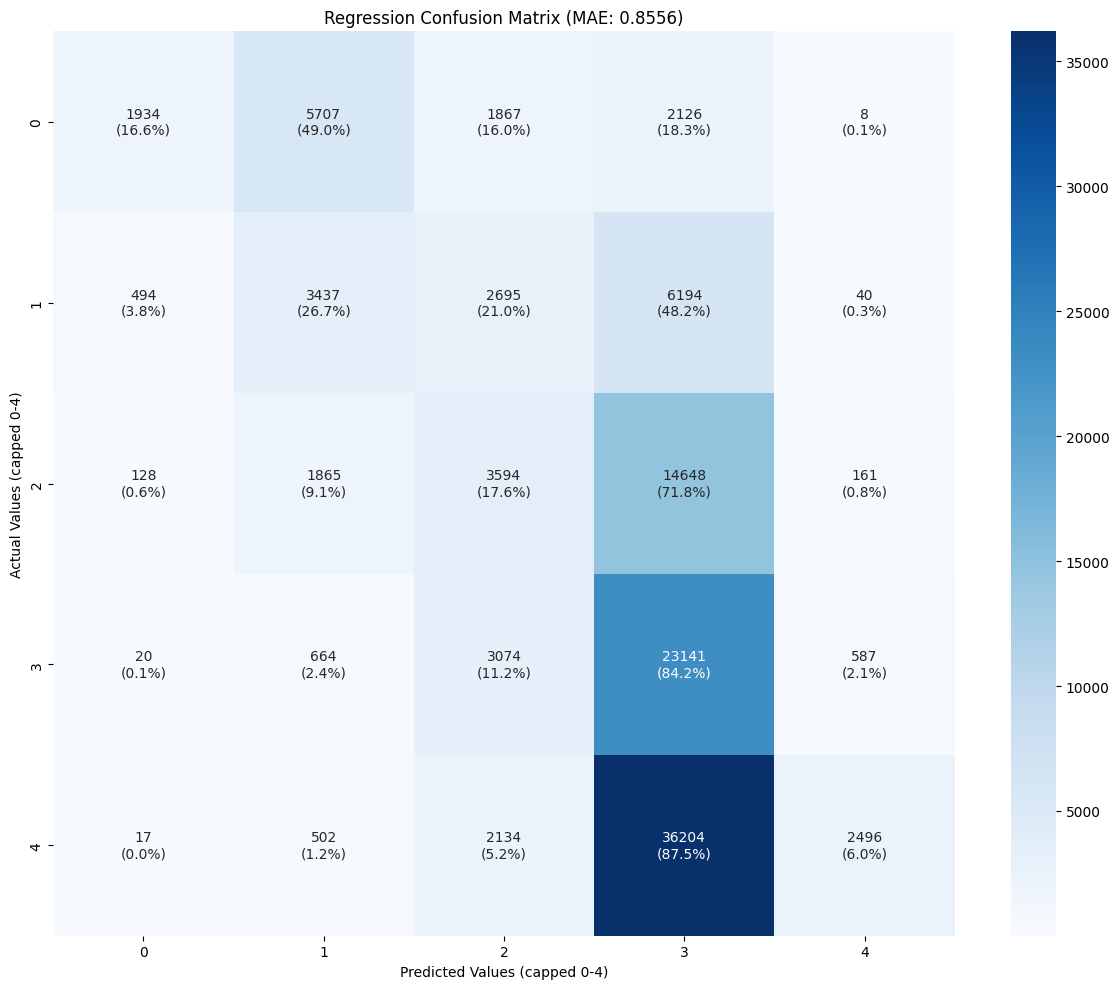

Original MAE (before capping): 0.8556
Overall accuracy (after capping and rounding): 30.42%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error

# Get predictions
y_pred_test = reg_model.predict(X_test)

# Calculate MAE (on original predictions, before capping)
mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 4)
y_pred_capped = np.clip(y_pred_test, 0, 4)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.5).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.5).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2, 3, 4])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Create a formatted annotation matrix combining counts and percentages
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values (capped 0-4)')
plt.ylabel('Actual Values (capped 0-4)')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

In [ ]:
# Get the nuber counts in y test
y_test.value_counts()

damage_grade
4    41353
3    27486
2    20396
1    12860
0    11642
Name: count, dtype: Int64